In [130]:
import sys
sys.path.append('../../')

import json
import pandas as pd
import numpy as np
from core.database import get_client
from sklearn.preprocessing import Imputer
from utils import centered_subways, get_nearest_undergroud, encode_with_OneHotEncoder_and_delete_column, encode_with_LabelEncoder, perform_coding_and_delete_column

In [131]:
client = get_client()
db = client.underpriced
flats = list(db.unprocessedFlats.find())

In [132]:
# df = pd.read_json("/home/alena/Documents/underpriced/aggregation_module/flats.json", orient='values')

In [133]:
df = pd.DataFrame.from_records(flats)

In [134]:
df.set_index(df['_id'], inplace=True)
df = df.drop('_id', axis=1)

In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15547 entries, 165528286 to 167205352
Data columns (total 28 columns):
address                    15547 non-null object
apartment_status           88 non-null object
area                       15546 non-null object
balcony                    15546 non-null object
ceiling_height             6407 non-null object
combined_bathroom_count    6805 non-null object
construction_year          10416 non-null object
description                15547 non-null object
district                   15547 non-null object
elevator                   10264 non-null object
floor                      15544 non-null object
house_type                 11774 non-null object
images                     15547 non-null object
kitchen_area               15546 non-null object
living_area                15546 non-null object
parking                    5303 non-null object
price                      15547 non-null object
processed                  549 non-null object
ramp      

In [136]:
df.rooms.value_counts()

2                                                    6283
1                                                    4177
3                                                    4154
4                                                     719
5                                                     140
студия на длительный срок (от года)                    54
многокомн. кв. на длительный срок (от года)            11
свободная планировка на длительный срок (от года)       3
студия на несколько месяцев (меньше года)               3
многокомн. кв. посуточно                                1
Name: rooms, dtype: int64

In [137]:
df.shape

(15547, 28)

In [138]:
df.price = df.price.map(lambda item: int(item['rub_price']) if 'rub_price' in item else np.nan)

In [139]:
df.price = df.price[df.price <= 200000]

In [140]:
df = df.dropna(axis=0, how='any', subset=['price'])

In [141]:
df.price.isnull().sum()

0

In [142]:
df.price.value_counts()

40000.0     1130
45000.0      924
30000.0      905
35000.0      842
50000.0      794
120000.0     553
55000.0      545
100000.0     537
90000.0      491
60000.0      483
28000.0      454
65000.0      426
70000.0      419
150000.0     414
25000.0      410
180000.0     375
75000.0      349
80000.0      327
33000.0      317
38000.0      299
32000.0      278
43000.0      253
85000.0      246
27000.0      240
42000.0      230
170000.0     202
95000.0      164
37000.0      161
48000.0      157
26000.0      154
            ... 
54999.0        1
173000.0       1
78500.0        1
102000.0       1
30900.0        1
153000.0       1
64900.0        1
14000.0        1
48500.0        1
65500.0        1
178000.0       1
29990.0        1
43200.0        1
54990.0        1
67500.0        1
75500.0        1
158000.0       1
56500.0        1
69999.0        1
34500.0        1
181000.0       1
47900.0        1
46500.0        1
99999.0        1
79500.0        1
24990.0        1
49990.0        1
104000.0      

In [143]:
df.shape

(15542, 28)

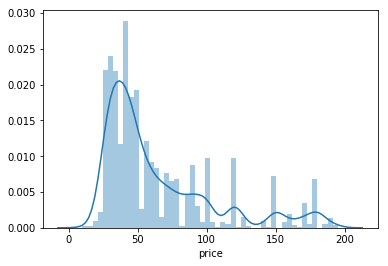

In [144]:
%matplotlib inline
import seaborn as sns

# Распределение квартир по цене:
sns.distplot(df.price / 1000);

In [98]:
df = df.drop(['apartment_status', 'address', 'description', 'images', 'district', 'room_area', 'url', 'view', 'processed'], axis=1)

In [99]:
# df = df.drop(['apartment_status', 'address', 'description', 'images', 'district', 'room_area', 'url', 'view'], axis=1)

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14945 entries, 165528286 to 166872179
Data columns (total 19 columns):
area                       14945 non-null object
balcony                    14945 non-null object
ceiling_height             6192 non-null object
combined_bathroom_count    6531 non-null object
construction_year          10018 non-null object
elevator                   9830 non-null object
floor                      14943 non-null object
house_type                 11322 non-null object
kitchen_area               14945 non-null object
living_area                14945 non-null object
parking                    5060 non-null object
price                      14945 non-null float64
ramp                       1537 non-null object
repair                     13653 non-null object
room_type                  4714 non-null object
rooms                      14943 non-null object
sleeping_place_count       27 non-null object
split_bathroom_count       6402 non-null object
underground

In [101]:
df.shape

(14945, 19)

In [102]:
# nulls more than a half
df = df.drop(['room_type', 'ceiling_height', 'parking', 'ramp', 'sleeping_place_count', 'split_bathroom_count', 'elevator'], axis=1)

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14945 entries, 165528286 to 166872179
Data columns (total 12 columns):
area                       14945 non-null object
balcony                    14945 non-null object
combined_bathroom_count    6531 non-null object
construction_year          10018 non-null object
floor                      14943 non-null object
house_type                 11322 non-null object
kitchen_area               14945 non-null object
living_area                14945 non-null object
price                      14945 non-null float64
repair                     13653 non-null object
rooms                      14943 non-null object
underground                14945 non-null object
dtypes: float64(1), object(11)
memory usage: 1.5+ MB


In [104]:
df = df.dropna(axis=0, how='any', subset=['area'])
df['area'] = df['area'].map(lambda x: float(x.replace(',', '.')) if ',' in x else float(x))

In [105]:
df['has_balcony'] = df['balcony'].map(lambda x: 1 if x.find(u'есть балкон') != -1 else 0)
df['has_loggia'] = df['balcony'].map(lambda x: 1 if x.find(u'есть лоджия') != -1 else 0)
df = df.drop('balcony', axis=1)

In [106]:
imputer = Imputer(missing_values=np.nan, strategy="median", axis=0)
df['combined_bathroom_count'] = imputer.fit_transform(df['combined_bathroom_count'].values.reshape(-1, 1))
df['combined_bathroom_count'] = df['combined_bathroom_count'].map(lambda x: int(x))

In [107]:
imputer = Imputer(missing_values=np.nan, strategy="median", axis=0)
df['construction_year'] = imputer.fit_transform(df['construction_year'].values.reshape(-1, 1))
df['construction_year'] = df['construction_year'].map(lambda x: int(x))

In [108]:
df = df.dropna(axis=0, how='any', subset=['floor'])

In [109]:
df['curr_floor'] = df['floor'].map(lambda x: int(str(x).split(' / ')[0]))
df['total_floor'] = df['floor'].map(lambda x: int(str(x).split(' / ')[1]))
df = df.drop('floor', axis=1)

In [110]:
df = df.dropna(axis=0, how='any', subset=['house_type'])

In [111]:
df['kitchen_area'] = df['kitchen_area'].map(lambda x: x.replace(',', '.') if ',' in x else x)
df.loc[df.kitchen_area == '–', 'kitchen_area'] = np.nan
df['kitchen_area'] = df['kitchen_area'].map(lambda x: float(x) if x is not None else x)
imputer = Imputer(missing_values=np.nan, strategy="mean", axis=0)
df['kitchen_area'] = imputer.fit_transform(df['kitchen_area'].values.reshape(-1, 1)) 

In [112]:
df['living_area'] = df['living_area'].map(lambda x: x.replace(',', '.') if ',' in x else x)
df.loc[df.living_area == '–', 'living_area'] = np.nan
df['living_area'] = df['living_area'].map(lambda x: float(x) if x is not None else x)
imputer = Imputer(missing_values=np.nan, strategy="mean", axis=0)
df['living_area'] = imputer.fit_transform(df['living_area'].values.reshape(-1, 1))

In [113]:
df.price.isnull().sum()

0

In [114]:
df = df.dropna(axis=0, how='any', subset=['repair'])

In [115]:
df['rooms'] = df['rooms'].map(lambda x: -1 if type(x) == str and x.find(u'студия') != -1 else x)
df['rooms'] = df['rooms'].map(lambda x: 6 if type(x) == str and x.find(u'многокомн') != -1 else x)
df['rooms'] = df['rooms'].map(lambda x: np.nan if type(x) == str and x == 'свободная планировка на длительный срок (от года)' else x)
df = df.dropna(axis=0, how='any', subset=['rooms'])
df['rooms'] = df['rooms'].map(lambda x: int(x))

In [116]:
df['underground'] = df['underground'].map(lambda x: np.nan if x == {} else x) 
df = df.dropna(axis=0, how='any', subset=['underground'])
df['underground_name'] = df['underground'].map(lambda item: str(get_nearest_undergroud(item)).lower())
df['is_center'] = df['underground_name'].map(lambda item: 1 if item in centered_subways else 0)

In [117]:
def get_way(item):
    if 'пешком' in item[get_nearest_undergroud(item)]:
        return -1
    if 'машине' in item[get_nearest_undergroud(item)]:
        return 1
    return None

In [118]:
df['underground_way'] = df.underground.map(lambda x: get_way(x))

In [119]:
df['underground_time'] = df.underground.map(lambda x: int(x[get_nearest_undergroud(x)].split(' ')[0]))

In [120]:
# nulls more than a half
df = df.drop(['underground'], axis=1)

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10796 entries, 165528286 to 166872179
Data columns (total 17 columns):
area                       10796 non-null float64
combined_bathroom_count    10796 non-null int64
construction_year          10796 non-null int64
house_type                 10796 non-null object
kitchen_area               10796 non-null float64
living_area                10796 non-null float64
price                      10796 non-null float64
repair                     10796 non-null object
rooms                      10796 non-null int64
has_balcony                10796 non-null int64
has_loggia                 10796 non-null int64
curr_floor                 10796 non-null int64
total_floor                10796 non-null int64
underground_name           10796 non-null object
is_center                  10796 non-null int64
underground_way            10796 non-null int64
underground_time           10796 non-null int64
dtypes: float64(4), int64(10), object(3)
memory usage: 1.

In [122]:
average_data = {}
for col in df.columns:
    if df[col].dtypes != object:
        average_data[col] = df[col].mean()

with open('average_data.json', 'w') as outfile:
    json.dump(average_data, outfile)

In [123]:
df.repair.isnull().sum()

0

In [124]:
df, metro_le_encoder = encode_with_OneHotEncoder_and_delete_column(df,'underground_name')
df, house_type_le_encoder = encode_with_OneHotEncoder_and_delete_column(df,'house_type')
df, repair_le_encoder = encode_with_OneHotEncoder_and_delete_column(df,'repair')

In [125]:
df.shape

(10796, 233)

In [126]:
with open('features.json', 'w') as outfile:
    all_columns = {}
    all_columns['features'] = df.columns.tolist()
    json.dump(all_columns, outfile)

In [127]:
df.to_csv('flats_data.csv')

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10796 entries, 165528286 to 166872179
Columns: 233 entries, area to repair=отсутствует
dtypes: float64(223), int64(10)
memory usage: 19.3+ MB


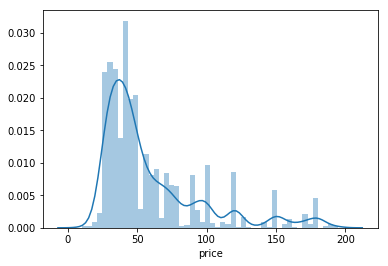

In [129]:
%matplotlib inline
import seaborn as sns

# Распределение квартир по цене:
sns.distplot(df.price / 1000);